In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import warnings
warnings.filterwarnings("ignore")
plt.style.use('ggplot')

import datetime
import calendar      #for calendar for datetime operations
import time          #to get the system time
plt.rcParams['figure.figsize'] = [16, 10] #set default figure size

from statsmodels.tsa.stattools import acf, pacf
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
from statsmodels.tsa import stattools

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df = pd.read_csv('/content/drive/MyDrive/train.csv')


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1458644 non-null  object 
 1   vendor_id           1458644 non-null  int64  
 2   pickup_datetime     1458644 non-null  object 
 3   dropoff_datetime    1458644 non-null  object 
 4   passenger_count     1458644 non-null  int64  
 5   pickup_longitude    1458644 non-null  float64
 6   pickup_latitude     1458644 non-null  float64
 7   dropoff_longitude   1458644 non-null  float64
 8   dropoff_latitude    1458644 non-null  float64
 9   store_and_fwd_flag  1458644 non-null  object 
 10  trip_duration       1458644 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


In [5]:
df['pickup_datetime'] = pd.to_datetime(df.pickup_datetime)
df.loc[:, 'pickup_date'] = df['pickup_datetime'].dt.date

#convert the following into a binary 1 indicator column
df['store_and_fwd_flag'] = 1 * (df.store_and_fwd_flag.values == 'Y')


In [6]:
west, south, east, north = -74.03, 40.63, -73.77, 40.85

df = df[(df.pickup_latitude> south) & (df.pickup_latitude < north)]
df = df[(df.dropoff_latitude> south) & (df.dropoff_latitude < north)]
df = df[(df.pickup_longitude> west) & (df.pickup_longitude < east)]
df = df[(df.dropoff_longitude> west) & (df.dropoff_longitude < east)]


In [7]:
#some datetime manipulations
df['pickup_datetime'] = pd.to_datetime(df.pickup_datetime)
df['dropoff_datetime'] = pd.to_datetime(df.dropoff_datetime)
# test['date'] = pd.to_datetime(test['pickup_date'])

df['date'] = pd.to_datetime(df.pickup_date)

In [8]:
df['Hour'] = df['pickup_datetime'].dt.hour
df['dayofweek'] = df['pickup_datetime'].dt.dayofweek
df['Month'] = df['pickup_datetime'].dt.month
df['dayofyear'] = df['pickup_datetime'].dt.dayofyear

Text(0.5, 1.0, 'Number of Rides over the Day')

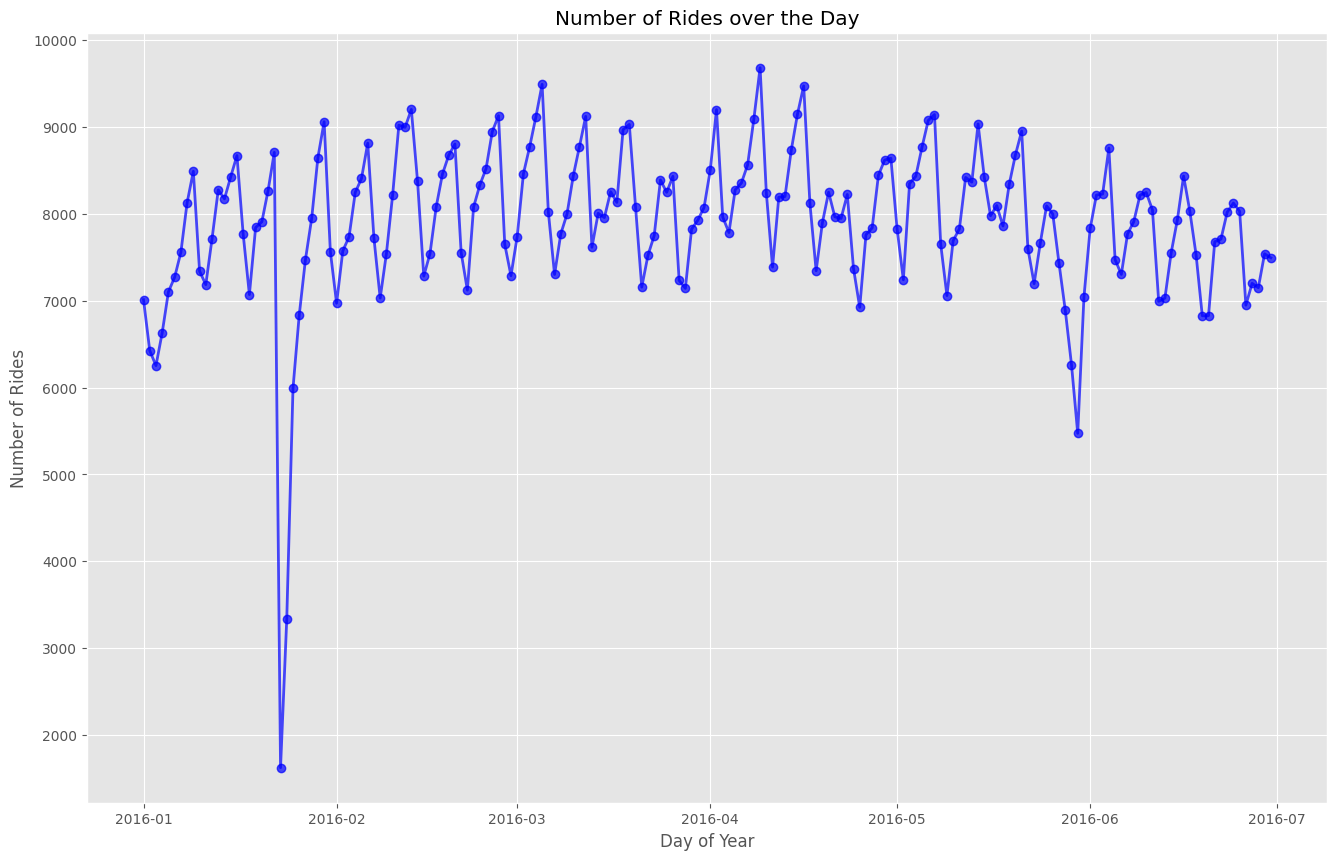

In [9]:
#plotting number of rides over the course of January to June

plt.plot(df.groupby('date').count()['id'], 'bo-', lw=2, alpha=0.7)
plt.xlabel('Day of Year')
plt.ylabel('Number of Rides')
plt.title('Number of Rides over the Day')

# Seasonal Adjustment with Differencing

Our time series contains weekly seasonal variation, which are cycles that repeat regularly over time.

In [10]:
count =  df.groupby('date').count()['id']
series = pd.DataFrame(({'day': count.index, 'count': count.values})).set_index('day')
series.head()

,count
day,
2016-01-01,7011
2016-01-02,6425
2016-01-03,6252
2016-01-04,6631
2016-01-05,7101


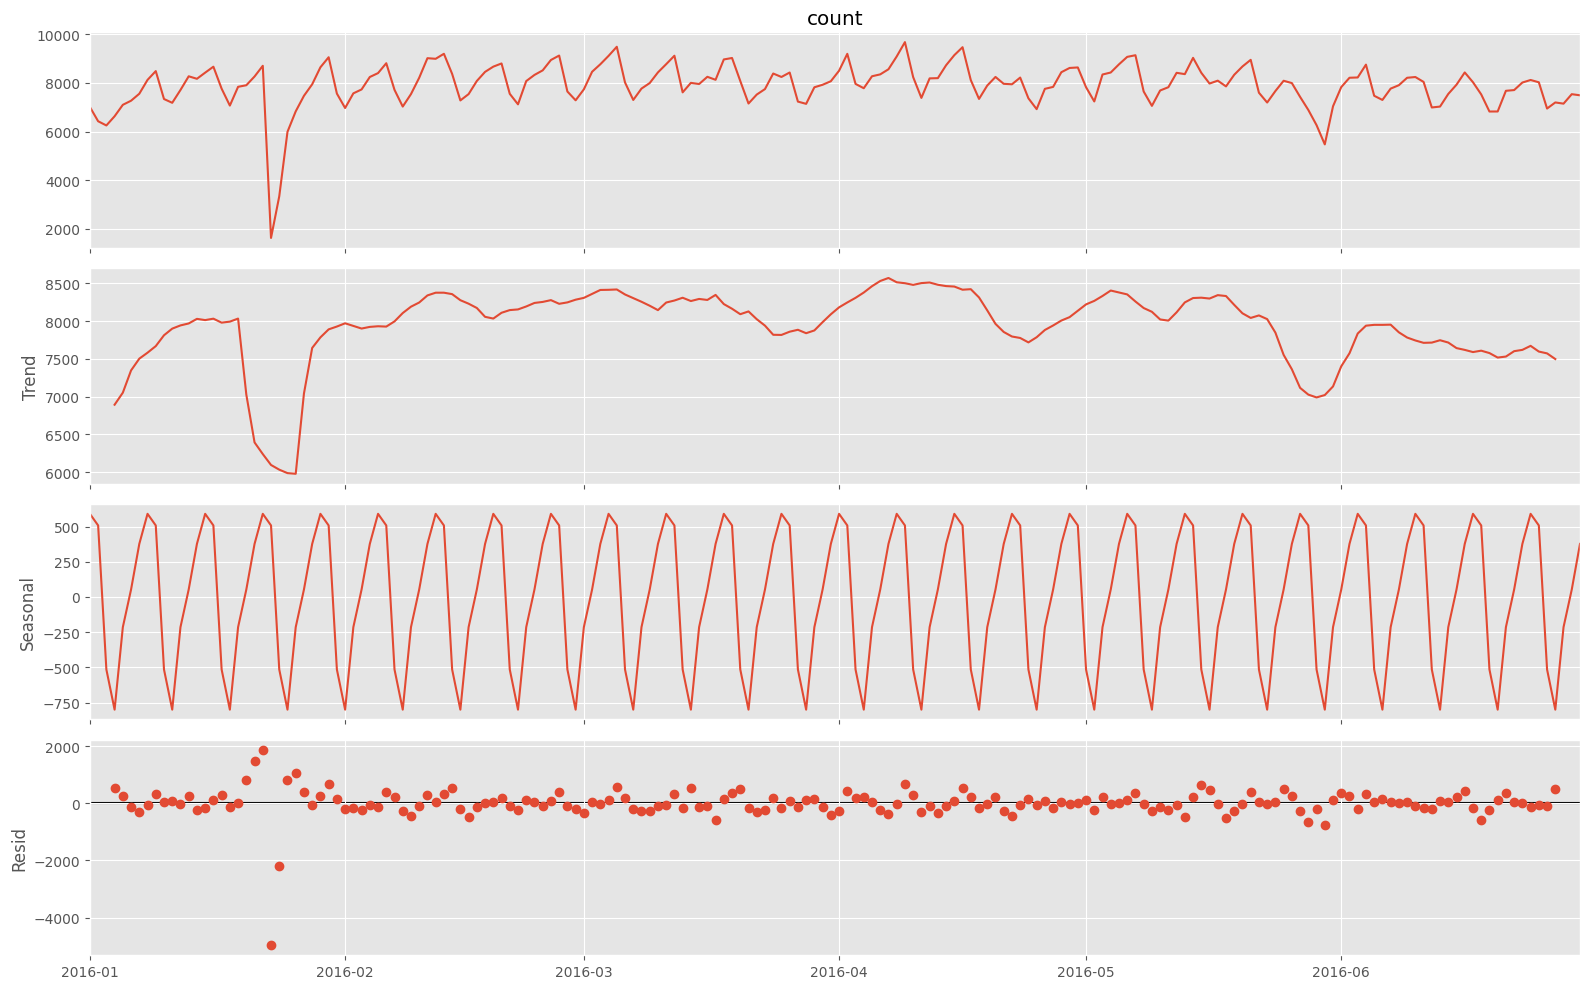

In [11]:
## ETS Graph (Error Trend Seasonality)

from statsmodels.tsa.seasonal import seasonal_decompose

result_ets = seasonal_decompose(series['count'],model='add')
result_ets.plot();

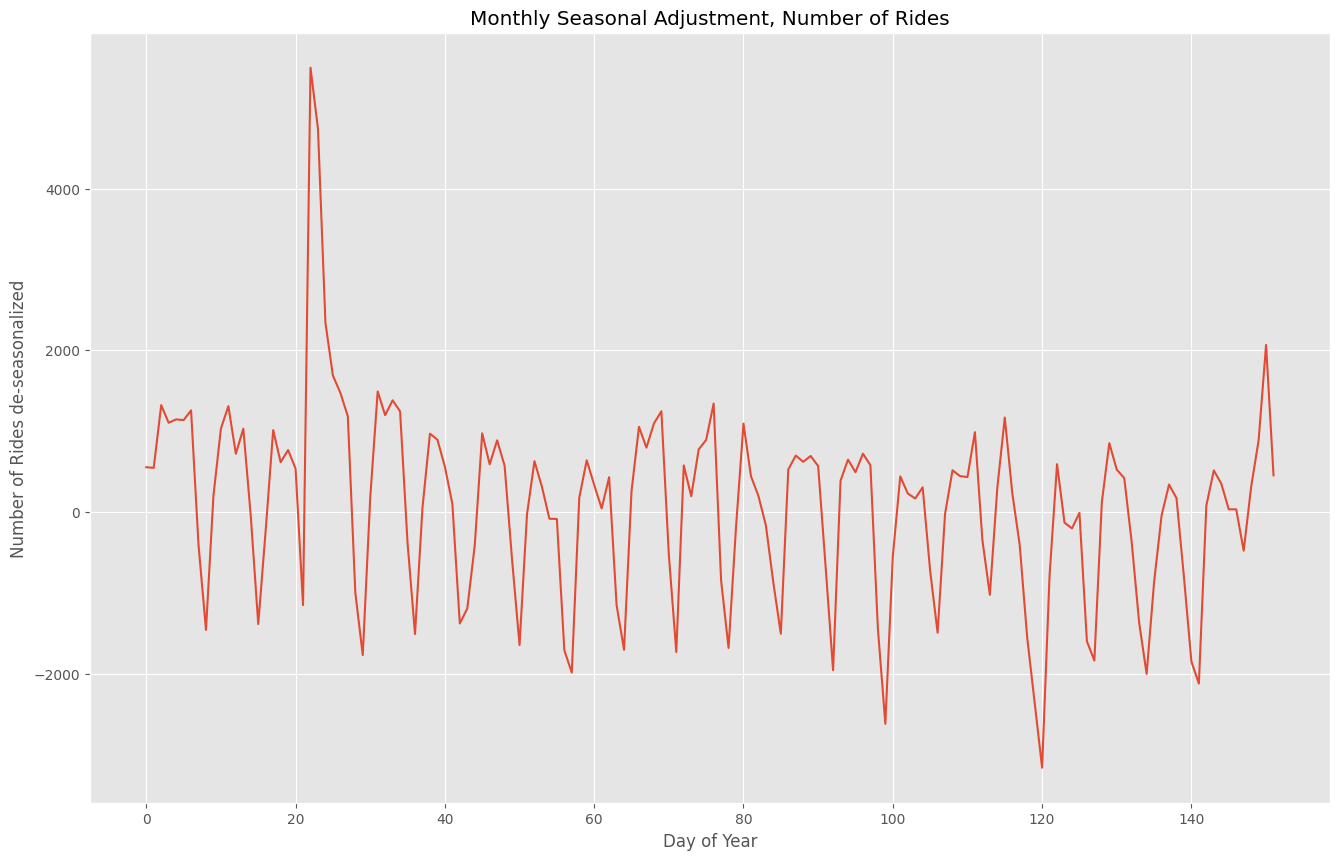

In [12]:
#Differncing by week for seasonal adjustment

X = series.values
diff = list()
days_in_month =30
for i in range(days_in_month, len(X)):
    value = X[i] - X[i - days_in_month]
    diff.append(value)
plt.plot(diff)
plt.xlabel('Day of Year')
plt.ylabel('Number of Rides de-seasonalized')
plt.title('Monthly Seasonal Adjustment, Number of Rides')
plt.show()

We can also consider the number fo rides within any given period of the year is probably stable. We can take this idea and consider all number of rides within a week to be stable. We can then subtract the average weekly number of rides from the previous week.


                  count
day                    
2016-01-03  6562.666667
2016-01-10  7502.142857
2016-01-17  8029.000000
2016-01-24  6393.428571
2016-01-31  7644.142857
2016-02-07  7922.714286
2016-02-14  8339.285714
2016-02-21  8056.000000
2016-02-28  8253.285714
2016-03-06  8411.714286
2016-03-13  8144.571429
2016-03-20  8346.142857
2016-03-27  7818.285714


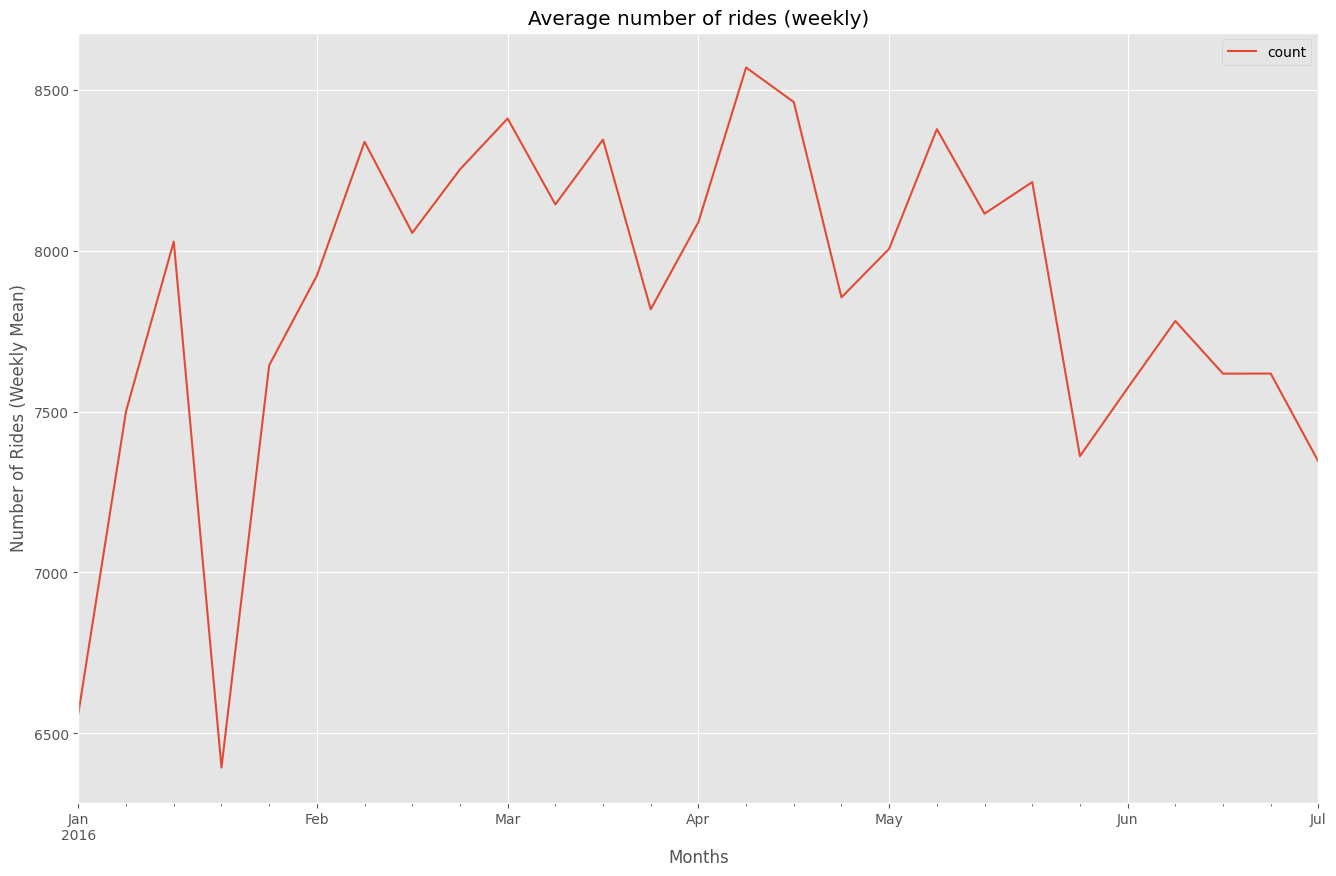

In [13]:
resample = series.resample('W')
weekly_mean = resample.mean()
print(weekly_mean.head(13))
weekly_mean.plot()
plt.xlabel('Months')
plt.ylabel('Number of Rides (Weekly Mean)')
plt.title('Average number of rides (weekly)')
plt.show()

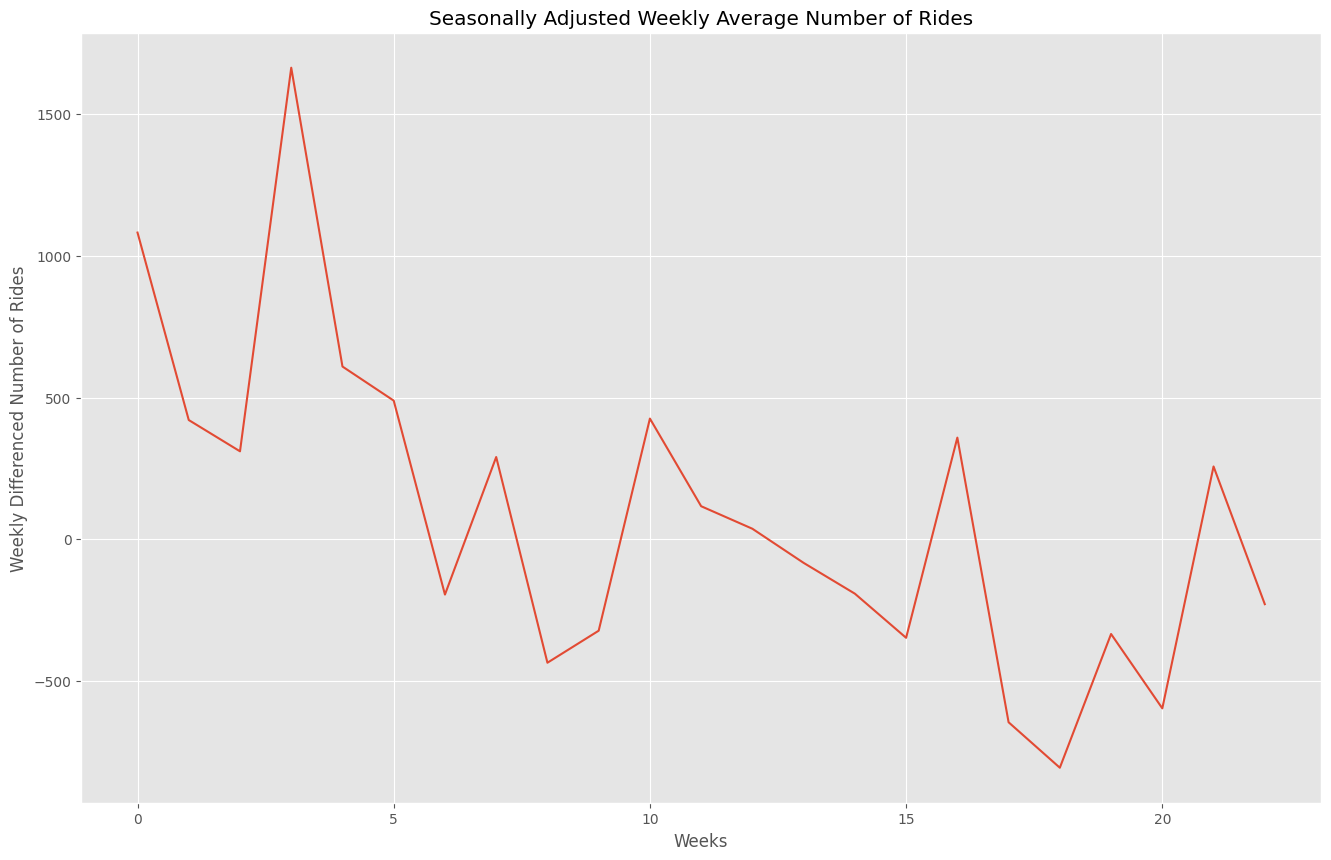

In [14]:
resample = series.resample('W')
weekly_mean = resample.mean()

diff = list()
weeks_in_month = 4
for i in range(weeks_in_month , len(weekly_mean)):
    value = weekly_mean.values[i] - weekly_mean.values[i - weeks_in_month]
    diff.append(value)
plt.plot(diff)
plt.xlabel('Weeks')
plt.ylabel('Weekly Differenced Number of Rides')
plt.title('Seasonally Adjusted Weekly Average Number of Rides')
plt.show()

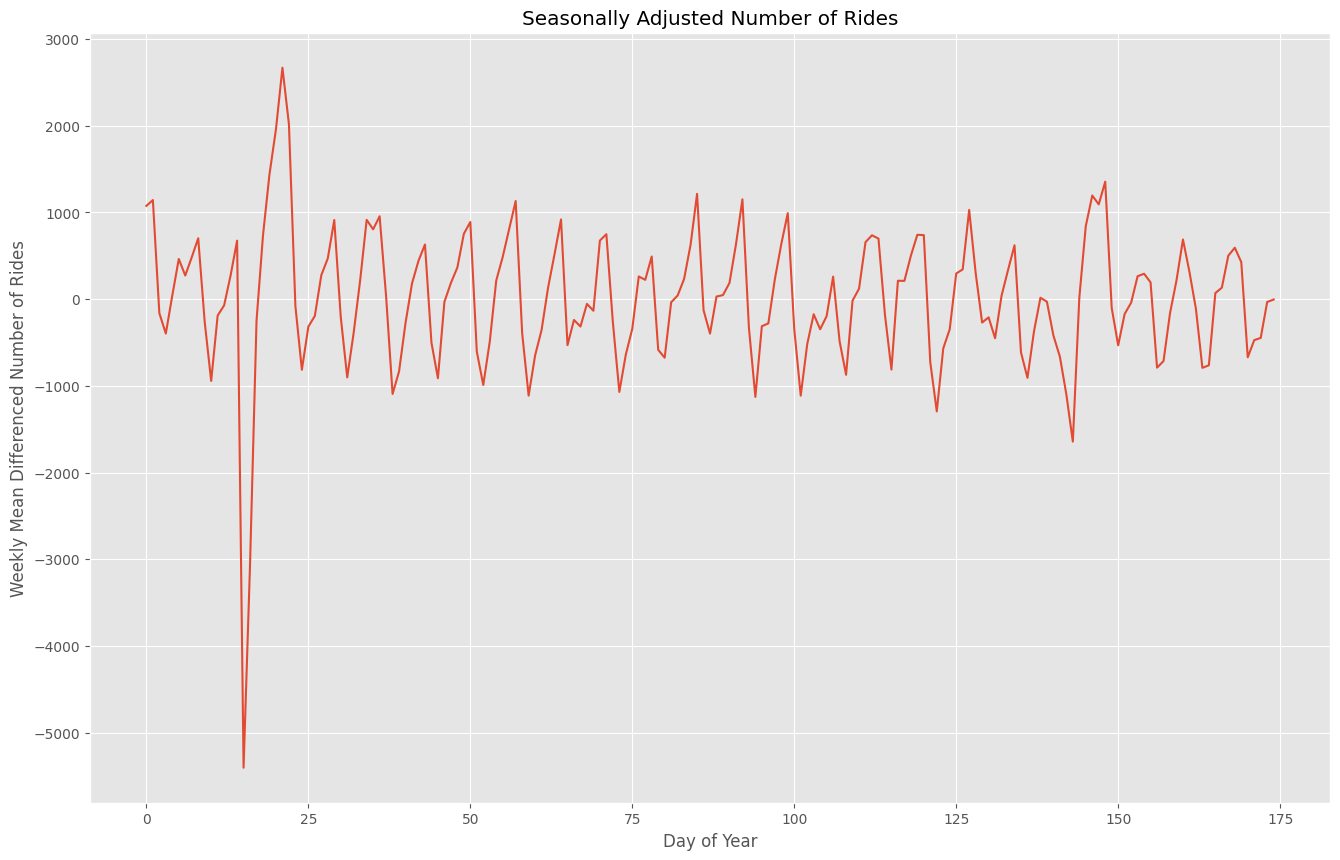

In [15]:
X = series.values
diff = list()
days_in_week = 7

for i in range(days_in_week, len(X)):
    date_ind = series.index[i].dayofyear
    last_week_mean = series.iloc[date_ind - 7 : date_ind].mean()
    value = X[i] - last_week_mean
    diff.append(value)

plt.plot(diff)
plt.xlabel('Day of Year')
plt.ylabel('Weekly Mean Differenced Number of Rides')
plt.title('Seasonally Adjusted Number of Rides')
plt.show()

# Seasonal Adjustment with Modeling

In [16]:
count1 =  df.groupby('date').count()['id']
series1 = pd.DataFrame(({'day': count1.index, 'count': count1.values}))
series1.head()

,day,count
0,2016-01-01,7011
1,2016-01-02,6425
2,2016-01-03,6252
3,2016-01-04,6631
4,2016-01-05,7101


In [17]:
series1.index.shape

(182,)

In [18]:
x_new =  series1.index.copy()

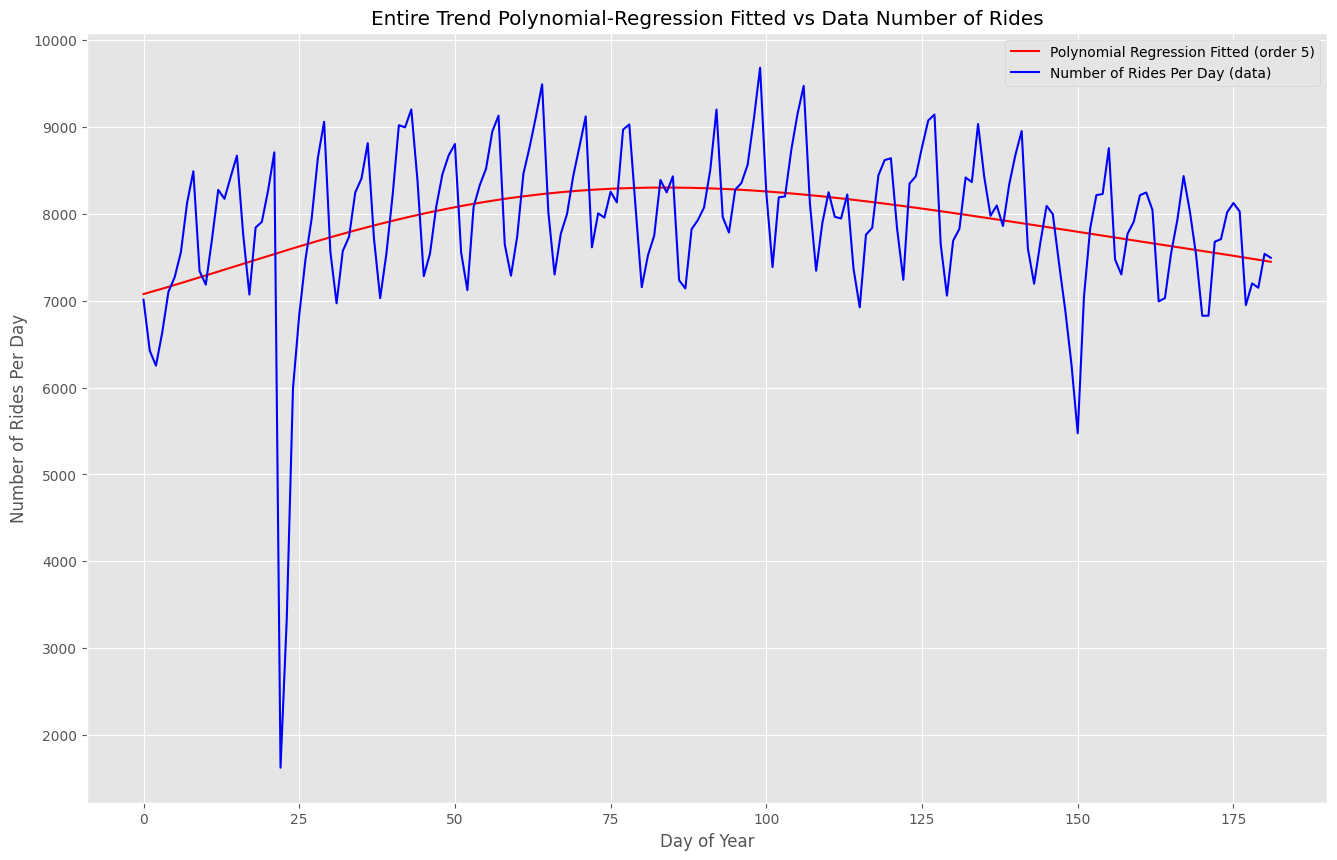

In [19]:
import numpy.polynomial.polynomial as poly
coefs = poly.polyfit(series1.index, series1['count'], 5)
ffit = poly.polyval(x_new, coefs)
plt.plot(x_new, ffit, color= 'red', label = 'Polynomial Regression Fitted (order 5)')
plt.plot(series.values, color= 'blue' , label = 'Number of Rides Per Day (data)')
plt.xlabel('Day of Year')
plt.ylabel('Number of Rides Per Day')
plt.title('Entire Trend Polynomial-Regression Fitted vs Data Number of Rides')
plt.legend()
plt.show()


np.polyfit cannot fit the regression line properly at the bigger scale, let's look at a week of increments, using the average values.

In [20]:
df['dayofweek'] = df['pickup_datetime'].dt.dayofweek

In [21]:
print('Tootal weeks in the duration of the time series : %i' %(len(series)/7))

Tootal weeks in the duration of the time series : 26


In [22]:
count2 =  df.groupby('dayofweek').count()['id']
series2 = pd.DataFrame(({'day': count2.index, 'count': count2.values / 26}))
series2.head()

,day,count
0,0,7111.653846
1,1,7697.538462
2,2,7978.307692
3,3,8291.423077
4,4,8481.269231


In [23]:
x_new1 =  series2.index.copy()

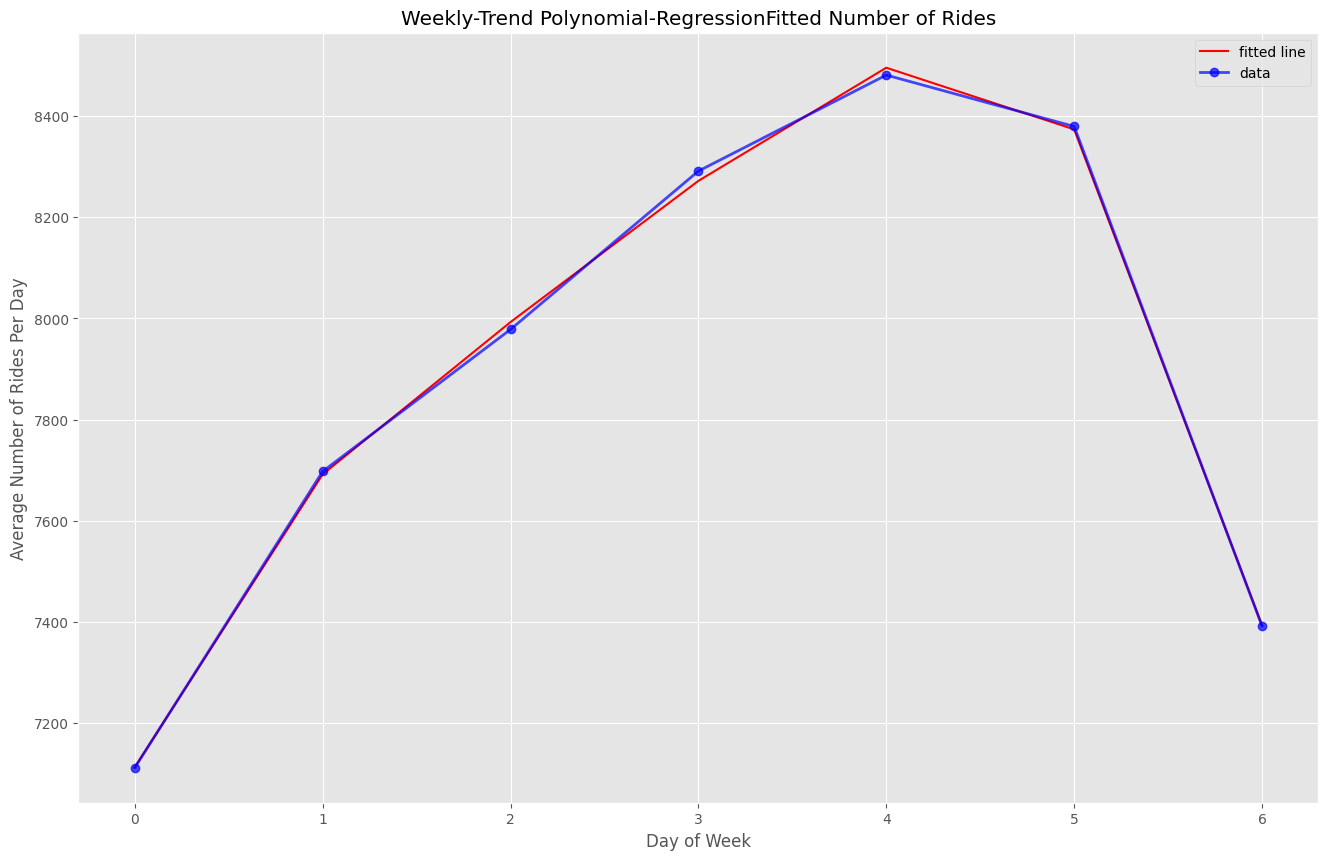

In [24]:
coefs = poly.polyfit(series2.index, series2['count'], 5)
ffit = poly.polyval(x_new1, coefs)
plt.plot(x_new1, ffit, color= 'red', label = 'fitted line')
plt.plot(df.groupby('dayofweek').count()['id'].index, (df.groupby('dayofweek').count()['id'].values / 26) , 'bo-', lw=2, alpha=0.7, label = 'data')
plt.legend()
plt.xlabel('Day of Week')
plt.ylabel('Average Number of Rides Per Day')
plt.title('Weekly-Trend Polynomial-RegressionFitted Number of Rides')
plt.show()
plt.show()

In [25]:
#ffit = poly.Polynomial(coefs)    # instead of np.poly1d
#plt.plot(x_new1, ffit(x_new1))

In [26]:
deseason = pd.DataFrame(({'dayofweek': x_new1 , 'fitted_count': ffit}))
deseason.head(10)


,dayofweek,fitted_count
0,0,7112.621795
1,1,7691.730769
2,2,7992.826923
3,3,8272.064103
4,4,8495.788462
5,5,8373.846154
6,6,7392.891026


In [27]:
count1 =  df.groupby('date').count()['id']
final = pd.DataFrame(({'day': count1.index, 'count': count1.values}))

In [28]:
final['dayofweek'] = final['day'].dt.dayofweek

In [29]:
final.head(10)

,day,count,dayofweek
0,2016-01-01,7011,4
1,2016-01-02,6425,5
2,2016-01-03,6252,6
3,2016-01-04,6631,0
4,2016-01-05,7101,1
5,2016-01-06,7270,2
6,2016-01-07,7557,3
7,2016-01-08,8127,4
8,2016-01-09,8489,5
9,2016-01-10,7340,6


Merge such that the final dataframe will contain both the actual count values for each day, and the corresponding fitted polynomial values for the day of week value resides in

In [30]:
final_df = pd.merge(final,
                    deseason[['dayofweek', 'fitted_count']],
                    left_on = 'dayofweek',
                    right_on = 'dayofweek',
                    how = 'left')


In [31]:
final_df['final_count'] = (round(final_df['count'] - final_df['fitted_count']))

In [32]:
final_df.head(10)

,day,count,dayofweek,fitted_count,final_count
0,2016-01-01,7011,4,8495.788462,-1485.0
1,2016-01-02,6425,5,8373.846154,-1949.0
2,2016-01-03,6252,6,7392.891026,-1141.0
3,2016-01-04,6631,0,7112.621795,-482.0
4,2016-01-05,7101,1,7691.730769,-591.0
5,2016-01-06,7270,2,7992.826923,-723.0
6,2016-01-07,7557,3,8272.064103,-715.0
7,2016-01-08,8127,4,8495.788462,-369.0
8,2016-01-09,8489,5,8373.846154,115.0
9,2016-01-10,7340,6,7392.891026,-53.0


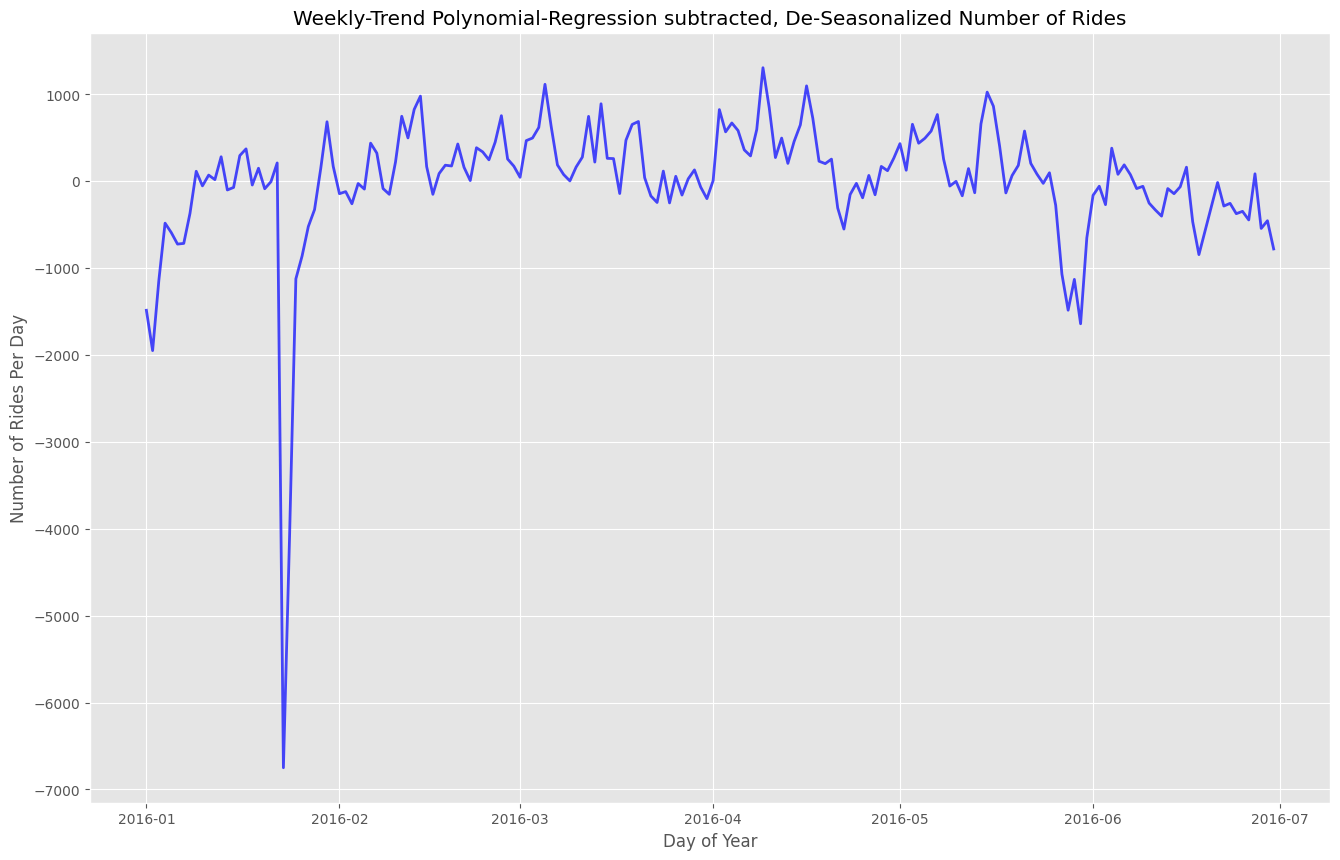

In [33]:
plt.plot(final_df.day, final_df.final_count , 'b-', lw=2, alpha=0.7)
plt.xlabel('Day of Year')
plt.ylabel('Number of Rides Per Day')
plt.title('Weekly-Trend Polynomial-Regression subtracted, De-Seasonalized Number of Rides')
plt.show()

In [34]:
clean_df =  final_df[31:]


In [35]:
clean_df.columns

Index(['day', 'count', 'dayofweek', 'fitted_count', 'final_count'], dtype='object')

In [36]:
df2 = clean_df[['day', 'final_count']]

In [37]:
df2.set_index('day', inplace = True)
df2.index = pd.RangeIndex(len(df2.index))
df2.head()

,final_count
0,-143.0
1,-119.0
2,-259.0
3,-26.0
4,-90.0


In [38]:
from statsmodels.tsa.stattools import adfuller

useful_values_raw = adfuller(df2['final_count'], autolag = 'AIC', regression = 'ct')[:5]
useful_values = [v for v in useful_values_raw[:4]]
useful_values.extend([useful_values_raw[4]['1%'], useful_values_raw[4]['5%'], useful_values_raw[4]['10%']])
pd.DataFrame({ 'Value':useful_values, 'Label':['Test Statistic','p-value','#Lags Used','Number of Observations Used', 'Critical value for 1%', 'Critical value for 5%', 'Critical value for 10%']})

,Value,Label
0,-5.445506,Test Statistic
1,0.000030,p-value
2,0.000000,#Lags Used
3,150.000000,Number of Observations Used
4,-4.020427,Critical value for 1%
5,-3.440174,Critical value for 5%
6,-3.144468,Critical value for 10%


In [39]:
def tsplot(y, lags=None, title='', figsize=(14, 8)):
    '''Examine the patterns of ACF and PACF, along with the time series plot and histogram.
    Source: https://tomaugspurger.github.io/modern-7-timeseries.html
    '''
    fig = plt.figure(figsize=figsize)
    layout = (2, 2)
    ts_ax   = plt.subplot2grid(layout, (0, 0))
    hist_ax = plt.subplot2grid(layout, (0, 1))
    acf_ax  = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))

    y.plot(ax=ts_ax)
    ts_ax.set_title(title)
    y.plot(ax=hist_ax, kind='hist', bins=25)
    hist_ax.set_title('Histogram')
    smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
    smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
    [ax.set_xlim(0) for ax in [acf_ax, pacf_ax]]
    sns.despine()
    fig.tight_layout()
    return ts_ax, acf_ax, pacf_ax

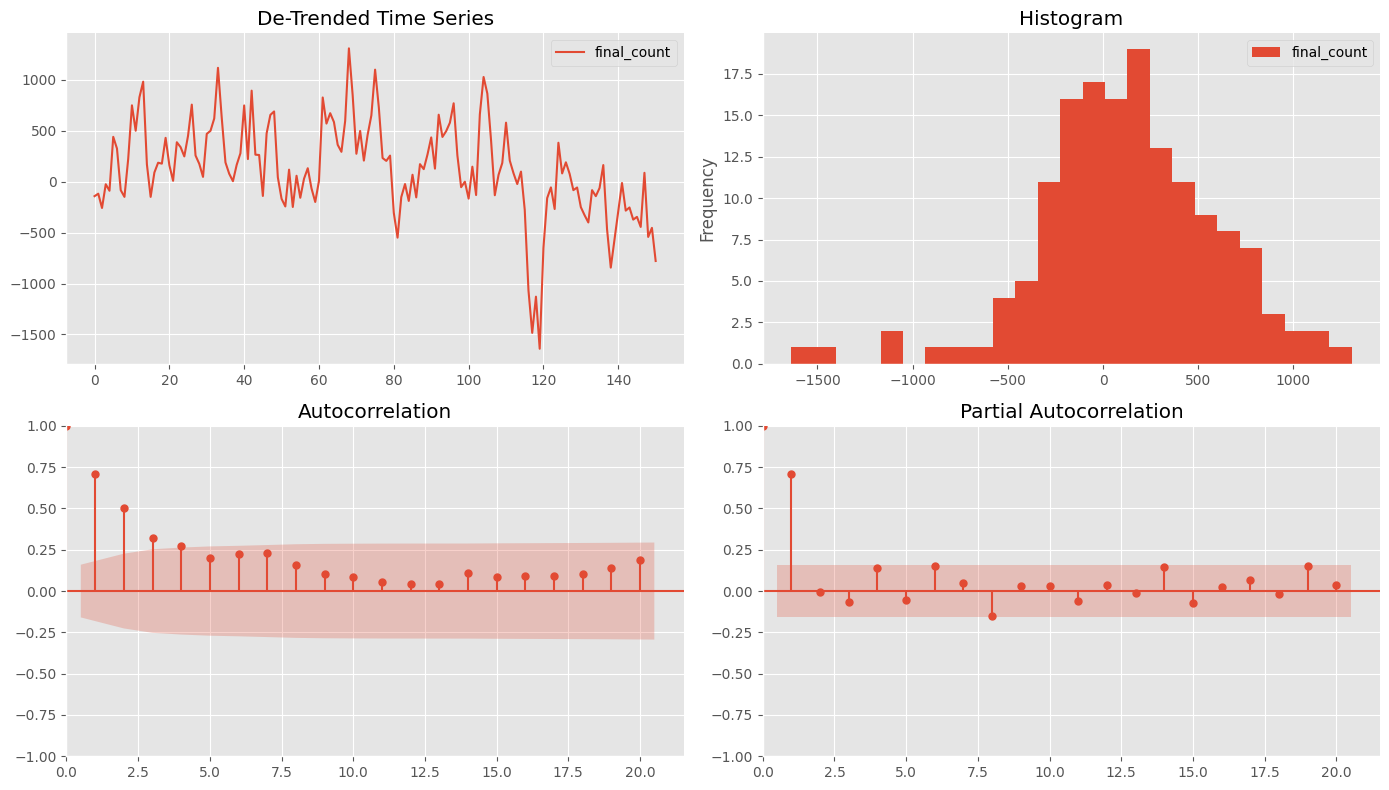

In [40]:
tsplot(df2, title='De-Trended Time Series', lags=20);

# SARIMAX Modelling

We can use the statsmodel's SARIMAX function to model a seasonal arima model on our dataset by prescribing a set of p,d,q variables. Calling the summary method on the fitted model then gives information about the fitted model including information criterion such as AIC and BIC.

We will also take the first 90% of the dataset as our prediction values, and leave out the most recent 10% of the dataset as the prediction (test) values. We dont want to take a random split of training and test datas because in this time series, we want to see how well we can predict our out of sample "future" values for ride demand.

In [41]:
n_sample = df2.shape[0]
print('New length of the entire dataset is : %i' %n_sample)

New length of the entire dataset is : 151


In [42]:
n_train=int(0.90*n_sample) + 1
n_forecast=n_sample-n_train

ts_train = df2.iloc[:n_train]['final_count']
ts_test = df2.iloc[n_train:]['final_count']

In [43]:
print(('Number of in sample training dataset : %i' %len(ts_train)))
print(('Number of out of sample testing dataset : %i' %len(ts_test)))

Number of in sample training dataset : 136
Number of out of sample testing dataset : 15


Including seasonal_order with the AR and MA component and period of 7 days (weekly).
Simple differencing is set to true such that we can forecast and calculate the error values later on the held out "future" data


In [44]:
arima101 = sm.tsa.statespace.SARIMAX(ts_train, order=(1,0,1), seasonal_order= (1,0,1,7), simple_differencing=True)
model_results = arima101.fit()
model_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                       final_count   No. Observations:                  136
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 7)   Log Likelihood                -969.758
Date:                           Mon, 25 Nov 2024   AIC                           1949.515
Time:                                   04:45:58   BIC                           1964.079
Sample:                                        0   HQIC                          1955.434
                                           - 136                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7246      0.062     11.752      0.000       0.604       0.845
ma.L1          0.0275      0.099      0.278      0.781      -0.166       0.221
ar.S.L7        0.9662      0.047     20.372      0.000       0.873       1.059
ma.S.L7       -0.8623      0.119     -7.231      0.000      -1.096      -0.629
sigma2      8.862e+04   1.03e+04      8.633      0.000    6.85e+04    1.09e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 7.00
Prob(Q):                              0.93   Prob(JB):                         0.03
Heteroskedasticity (H):               1.56   Skew:                            -0.29
Prob(H) (two-sided):                  0.14   Kurtosis:                         3.95
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [45]:
import pickle

# Save the SARIMAX results object to a .pkl file
with open('sarimax_model_results.pkl', 'wb') as file:
    pickle.dump(model_results, file)

print("SARIMAX model saved to 'sarimax_model_results.pkl'")


SARIMAX model saved to 'sarimax_model_results.pkl'


In [46]:
#credit to Jeffery Yau @ https://www.youtube.com/watch?v=tJ-O3hk1vRwhttps://www.youtube.com/watch?v=tJ-O3hk1vRw
#PyData SF2016 conference

import itertools

p_min = 0
d_min = 0
q_min = 0
p_max = 4
d_max = 0
q_max = 4

# Initialize a DataFrame to store the results
results_bic = pd.DataFrame(index=['AR{}'.format(i) for i in range(p_min,p_max+1)],
                           columns=['MA{}'.format(i) for i in range(q_min,q_max+1)])

for p,d,q in itertools.product(range(p_min,p_max+1),
                               range(d_min,d_max+1),
                               range(q_min,q_max+1)):
    if p==0 and d==0 and q==0:
        results_bic.loc['AR{}'.format(p), 'MA{}'.format(q)] = np.nan
        continue

    try:
        model = sm.tsa.SARIMAX(ts_train, order=(p, d, q),
                               #enforce_stationarity=False,
                               #enforce_invertibility=False,
                              )
        results = model.fit()
        results_bic.loc['AR{}'.format(p), 'MA{}'.format(q)] = results.bic
    except:
        continue
results_bic = results_bic[results_bic.columns].astype(float)

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood op

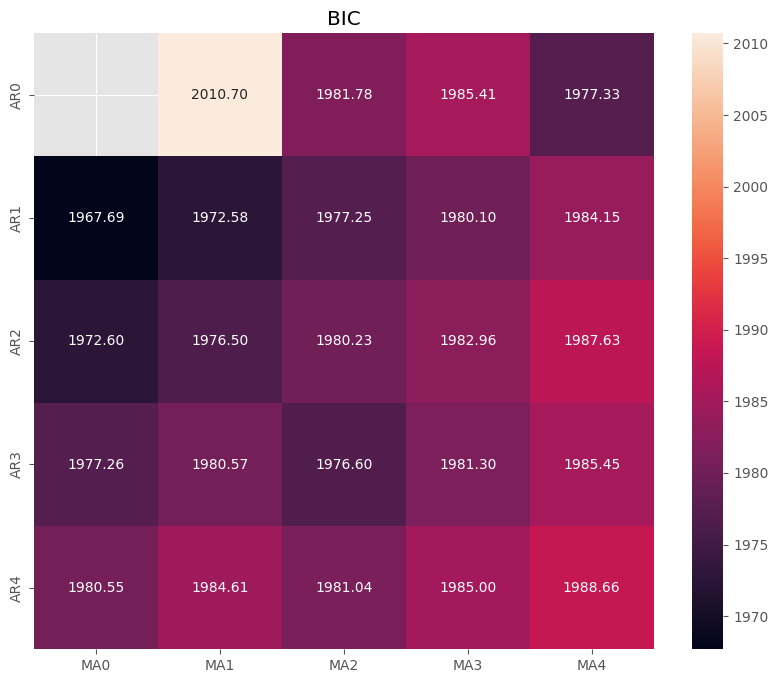

In [47]:
fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(results_bic,
                 mask=results_bic.isnull(),
                 ax=ax,
                 annot=True,
                 fmt='.2f',
                 );
ax.set_title('BIC');

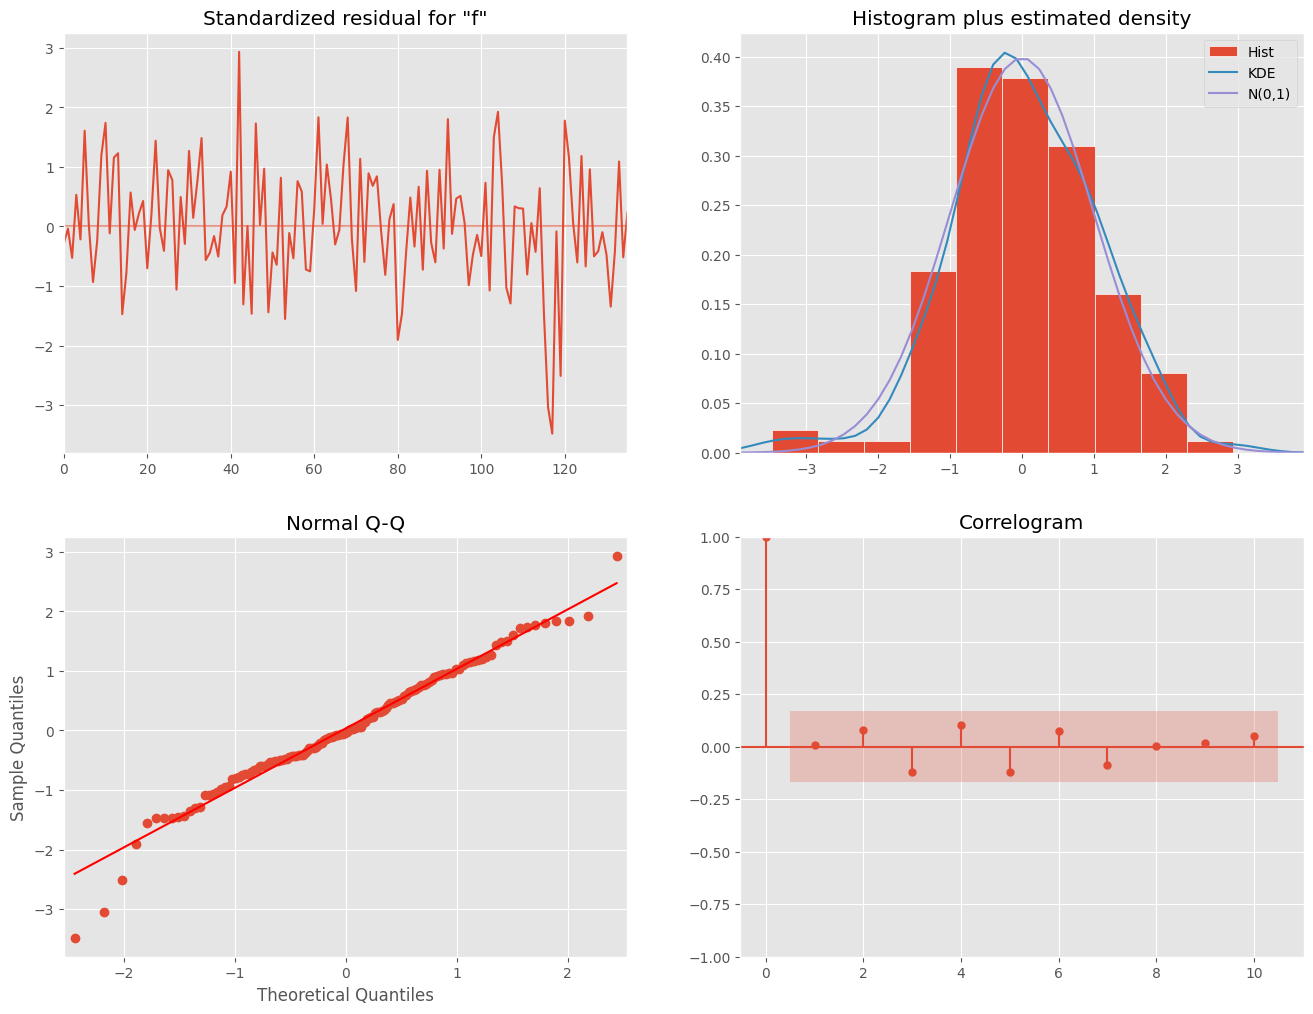

In [48]:
model_results.plot_diagnostics(figsize=(16, 12));

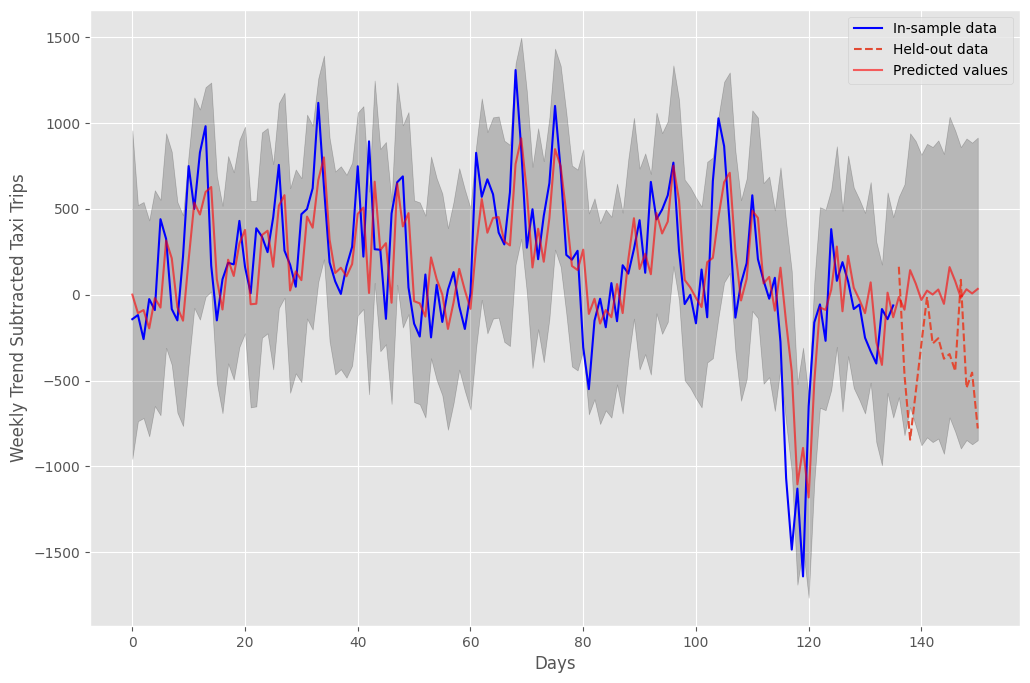

In [49]:
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(12, 8))

ax1.plot(ts_train, color = 'blue', label='In-sample data', linestyle='-')
# subtract 1 only to connect it to previous point in the graph
ax1.plot(ts_test, label='Held-out data', linestyle='--')

pred_begin = ts_train.index[model_results.loglikelihood_burn]
pred_end = ts_test.index[-1]
pred = model_results.get_prediction(start=pred_begin,
                                    end=pred_end)
pred_mean = pred.predicted_mean
pred_ci = pred.conf_int(alpha=0.05)

ax1.plot(pred_mean, 'r', alpha=.6, label='Predicted values')
ax1.fill_between(pred_ci.index,
                 pred_ci.iloc[:, 0],
                 pred_ci.iloc[:, 1], color='k', alpha=.2)
plt.xlabel('Days')
plt.ylabel('Weekly Trend Subtracted Taxi Trips')
ax1.legend(loc='best');

In [50]:
def get_rmse(y, y_hat):

    mse = np.mean((y - y_hat)**2)
    return np.sqrt(mse)

In [51]:
rmse1 = get_rmse(ts_train, pred_mean.iloc[ts_train.index])
print("In sample RMSE: %.4f" % rmse1)

rmse2 = get_rmse(ts_test, pred_mean.iloc[-15:])
print("Out of Sample forecast RMSE: %.4f" % rmse2)


In sample RMSE: 300.8069
Out of Sample forecast RMSE: 491.0578


With our SARIMAX model, we achieve an in sample RMSE error value of 300, while we achieve an out of sample forecast RMLSE of 490. While our forecast model was only 15 data samples, we get a promising error metric, when considering that there are more than 7 thousand trips on average given any day in NYC.



In [52]:
pred_df = pd.DataFrame({'pred_count': pred_mean})

In [53]:
clean_df.index = pd.RangeIndex(len(clean_df.index))
clean_df.head()

,day,count,dayofweek,fitted_count,final_count
0,2016-02-01,6970,0,7112.621795,-143.0
1,2016-02-02,7573,1,7691.730769,-119.0
2,2016-02-03,7734,2,7992.826923,-259.0
3,2016-02-04,8246,3,8272.064103,-26.0
4,2016-02-05,8406,4,8495.788462,-90.0


In [54]:
result_df = clean_df.join(pred_df, how ='outer')
result_df['pred_fit'] = result_df['fitted_count'] + result_df['pred_count']
result_df.head()

,day,count,dayofweek,fitted_count,final_count,pred_count,pred_fit
0,2016-02-01,6970,0,7112.621795,-143.0,0.000000,7112.621795
1,2016-02-02,7573,1,7691.730769,-119.0,-107.689040,7584.041729
2,2016-02-03,7734,2,7992.826923,-259.0,-89.793514,7903.033409
3,2016-02-04,8246,3,8272.064103,-26.0,-196.539570,8075.524533
4,2016-02-05,8406,4,8495.788462,-90.0,-20.508765,8475.279696


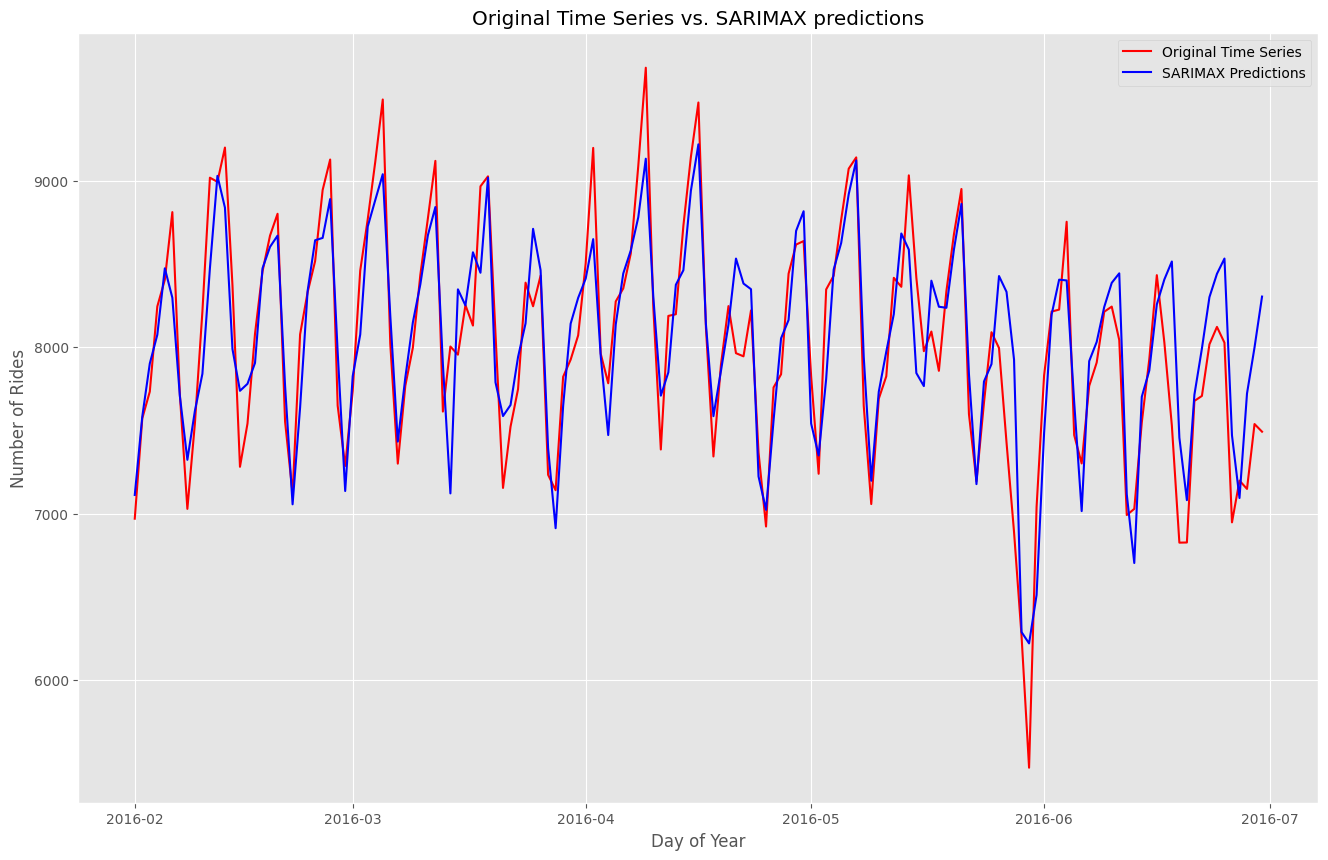

In [55]:
plt.plot(result_df['day'], result_df['count'], color = 'red', label = 'Original Time Series')
plt.plot(result_df['day'], result_df['pred_fit'], color = 'blue', label = 'SARIMAX Predictions')
plt.xlabel('Day of Year')
plt.ylabel('Number of Rides')
plt.title('Original Time Series vs. SARIMAX predictions')
plt.legend()
plt.show()

In [56]:
pip install dash plotly pandas statsmodels


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 75.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 228.0/228.0 kB 21.1 MB/s eta 0:00:00
  Attempting uninstall: Werkzeug
    Found existing installation: Werkzeug 3.1.3
    Uninstalling Werkzeug-3.1.3:
      Successfully uninstalled Werkzeug-3.1.3


In [57]:
import dash
from dash import dcc, html, Input, Output
import plotly.graph_objects as go
import pandas as pd
import datetime as dt
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pandas as pd

# Define the data
data = {
    "index": [0, 1, 2, 3, 4, 5, 6],
    "dayofweek": [0, 1, 2, 3, 4, 5, 6],
    "fitted_count": [
        7112.621794871772,
        7691.730769230754,
        7992.826923076907,
        8272.064102564089,
        8495.788461538452,
        8373.846153846152,
        7392.891025641042
    ]
}
# Create the DataFrame
deseason = pd.DataFrame(data)

# Set 'index' as the DataFrame index
deseason.set_index("index", inplace=True)


# Train SARIMAX model (replace with your existing implementation)
with open('sarimax_model_results.pkl', 'rb') as file:
    results = pickle.load(file)

# Ensure the index is in datetime format
min_date = pd.to_datetime("2016-02-15").strftime('%Y-%m-%d')
cutoff_date = pd.to_datetime("2026-12-31")
max_date = cutoff_date.strftime('%Y-%m-%d')

# Initialize Dash app
app = dash.Dash(__name__)

app.layout = html.Div([
    html.H1("Interactive Trip Forecasting"),
    dcc.DatePickerSingle(
        id='date-picker',
        min_date_allowed=min_date,
        max_date_allowed=max_date,
        initial_visible_month=min_date,
        date=min_date
    ),
    html.Div(id='forecast-output', style={'margin-top': '20px'}),
    dcc.Graph(id='time-series-plot')
])

@app.callback(
    [Output('forecast-output', 'children'),
     Output('time-series-plot', 'figure')],
    [Input('date-picker', 'date')]
)
def update_forecast(selected_date):
    if not selected_date:
        return "Please select a date.", go.Figure()

    try:
        selected_date = pd.to_datetime(selected_date)
        forecast_steps = 30

        # Create the time series plot
        fig = go.Figure()

        # Determine the 30-day range for historical and forecasted data
        start_date = selected_date - pd.Timedelta(days=30)
        end_date = selected_date

        forecast_message = ""
        if forecast_steps > 0:
            # Case: Selected date is in the future
            forecast = results.get_forecast(steps=forecast_steps)
            future_dates = pd.date_range(start=start_date + pd.Timedelta(days=1), periods=forecast_steps)
            forecast_values = forecast.predicted_mean

            # Adjust forecast using deseasonalization
            future_days_of_week = future_dates.dayofweek  # Get the day of the week for future dates
            fitted_counts = [
                deseason[deseason['dayofweek'] == day]['fitted_count'].mean()+np.random.randint(0,1000)  # Use mean if multiple entries exist
                for day in future_days_of_week
            ]
            adjusted_forecast_values = forecast_values + fitted_counts

            # Restrict to the last 30 days relative to the selected date
            forecast_data = pd.DataFrame({'date': future_dates, 'forecast': adjusted_forecast_values})
            forecast_data = forecast_data[(forecast_data['date'] >= start_date) & (forecast_data['date'] <= end_date)]

            # Add forecasted data to the plot
            if not forecast_data.empty:
                fig.add_trace(go.Scatter(
                    x=forecast_data['date'],
                    y=forecast_data['forecast'],
                    mode='lines',
                    name='Forecast',
                    line=dict(color='orange', dash='dash')
                ))

            forecast_message = f"Forecasted trips on {selected_date.date()}: {adjusted_forecast_values.iloc[-1]:.2f}"

        # Update the layout
        fig.update_layout(
            title="Time Series of Trips with Forecast (Last 30 Days)",
            xaxis_title="Date",
            yaxis_title="Number of Trips",
            template="plotly_white",
            legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1)
        )

        return forecast_message, fig

    except Exception as e:
        # Handle unexpected errors
        return f"An error occurred: {str(e)}", go.Figure()


if __name__ == '__main__':
    app.run_server(debug=True)


<IPython.core.display.Javascript object>